# Network Solver

Das Dokument war der Versuch drei verschiedenen Ansätzen folgend Algorithmen zu implementieren um die Stöme über Widerstände zu berechnen, wenn Netzwerkgeometrie, Knotenpotentiale und Widerstandswerte bekannt sind. Es sollte sich später herausstellen, dass die zwei Ansätze am Ende des Dokuments nicht dafür geeignet waren, oder nicht ausreichend beschrieben waren.

### Gedanken zum Initialisieren des Netzwerkes
Die Beschaffenheit des Problems aus Edges, Nodes und Flows legt die Betrachtung als Graph nahe und damit die Implementierung es Netzes mit Networkx

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import copy, random
import numpy as np

In [2]:
#Initialize Lattice
x1=2
x2=2
x3=2
G = nx.grid_graph(dim=(x1,x2))
G3 = nx.grid_graph(dim=(x1,x2,x3)) #3D Grid
#Adjacency Matrix
A=nx.adjacency_matrix(G, dtype = "float32")
A3=nx.adjacency_matrix(G3, dtype = "float32")

/tmp/ipykernel_12636/3917560671.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A=nx.adjacency_matrix(G, dtype = "float32")
/tmp/ipykernel_12636/3917560671.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A3=nx.adjacency_matrix(G3, dtype = "float32")


In [3]:
#nx.draw_networkx(G3)

#### Note: 
Die Darstellung der Graphen ist häufig verzogen, stabilisiert sich aber nach mehrfachausführung einer Zelle häufig. Des weiteren wird die Ästetik des Graphen negativ durch das Zuweisen von Widerstände beeinflusst, weil die Zeichnung versucht diese Verhältnismäßigkeiten wiederzugeben

**Random ValuesAuch wenn das bisher nirgendwo im Code explizit verwendet wurde, wollte ich verschiedene Potentiale und Widerstände haben und habe deshalb mit Gauss-verteilten Werten angefangen.

In [4]:
#Randomize Resistances
R_0=1
sigmaR=0.05

for (u, v) in G.edges(): #die beiden Endpunkte u und v der Kante
    G.edges[u,v]['weight'] = random.normalvariate(R_0, sigmaR)

R=nx.adjacency_matrix(G, dtype = "float32").todense()

/tmp/ipykernel_12636/4251003308.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  R=nx.adjacency_matrix(G, dtype = "float32").todense()


In [5]:
#Randomize 3D Resistances
R_0=1
sigmaR=0.05

for (u, v) in G3.edges():
    G3.edges[u,v]['weight'] = random.normalvariate(R_0, sigmaR)
    #G3.edges[u,v]['weight'] = 1

R3=nx.adjacency_matrix(G3, dtype = "float32").todense()

/tmp/ipykernel_12636/123006906.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  R3=nx.adjacency_matrix(G3, dtype = "float32").todense()


In [6]:
#Randomize 2D Potentials
P_0=0
sigmaP=0.5

for (i,j) in G.nodes: #Koordinaten im Gittter
    G.nodes[i,j]['potential'] = random.normalvariate(P_0, sigmaP)
labels = nx.get_node_attributes(G, 'potential') 

In [7]:
#Randomize 3D Potentials
P_0=0
sigmaP=0.5

for (i,j,k) in G3.nodes:
    G3.nodes[i,j,k]['potential'] = random.normalvariate(P_0, sigmaP)
labels3 = nx.get_node_attributes(G3, 'potential') 

In [8]:
#nx.draw_networkx(G3, labels=labels3)

In [9]:
#print(R3)

## Lösungsansätze aus verschiedenen Papern
Es folgen jeweils eine kurze Zusammenfassung des relavanten Teils aus den Papern und dann der Versuch das zu implementieren

### Following the Paper: Efficient Methods for Large Resistor Networks - Rommes und Schilders 2010

Das Gleichungssystem kann formuliert werden als
$$
\left[\begin{array}{cc}
R & P \\
-P^T & 0
\end{array}\right]\left[\begin{array}{c}
\mathbf{i}_b \\
\mathbf{v}
\end{array}\right]=\left[\begin{array}{l}
\mathbf{0} \\
\mathbf{i}_n
\end{array}\right]
$$
mit Widerstandsmatrix $R $ (Widerstände auf der Hauptdiagonalen) und der Inzidenzmatrix $P$. Für uns relevant sind die Widerstandsströme $ \mathbf{i}_b $.   
Mit Hilfe der Ersetzung $i_b=$ $-R^{-1} P \mathbf{v}$ führt das zu der Formulierung
$$
G \mathbf{v}=\mathbf{i}_n
$$
mit der Leitfähigkeitsmatrix $G=P^T R^{-1} P \in \mathbb{R}^{n \times n}$. Nach Aufteilung der Knoten in innenliegende und außenliegende (welche auch Strom aufnehmen können):
$$
\left[\begin{array}{ll}
G_{11} & G_{12} \\
G_{12}^T & G_{22}
\end{array}\right]\left[\begin{array}{l}
\mathbf{v}_e \\
\mathbf{v}_i
\end{array}\right]=\left[\begin{array}{l}
B \\
0
\end{array}\right] \mathbf{i}_e
$$
mit externen Strömen $\mathbf{i}_e$.   
Ein Knoten muss als Referenz genommen werden. Das Potential wird auf Null gesetzt und alle zugehörigen Gleichungen werden entfernt. (Die resultierende Matrix wird weiterhin $G$ genannt.)

Um das Problem zu lösen wird $G$ mittels Cholesky Zerlegung in zwei Dreiecksmatrizen zerlegt $G=LL^T$. (Das kann schneller gemacht werden mit AMD.) Die Spannungen werden berechnet durch $ \mathbf{v}=G^{-1} \mathbf{i}_n$ wobei das schrittweise durch $L \mathbf{x}=\mathbf{i}_n$ und $L^{T} \mathbf{v}=\mathbf{x}$. Schließlich wird der Strom durch $-R^{-1} P \mathbf{v}=i_b$ berechnet.

#### Bemerkung:
*Für die Berechnung der Ströme über Widerstände sind also konkret die Widerstandswerte, die Inzidenzmatrix und die Potentialdifferenz zwischen Knoten nötig. Der Rest ist nötig um die Potentialwerte an den Knoten zu berechnen. Bei uns sind diese Werte allerdings bekannt. Das vereinfacht das Problem wahrscheinlich immens, allerdings müssen wir nochmal darüber nachdenken ob KVL für unsere Potenitale gerechtfertigt ist*

#### Bemerkung 2:
*Da das elektrische Feld ein konservatives Feld ist, sollte Kirchhoffs-Voltage-Law gelten.*

In [10]:
class Rommes:
    def __init__(self, X):
        self.G=X
        self.N=self.G.order()
        self.nR=self.G.number_of_edges()
        
    def resistor(self):
        #Extract the values of the resistors from the graph and build a nR x nR matrix
        mat=np.zeros((self.nR,self.nR))
        i=0
        for (u, v) in self.G.edges():
            mat[i,i]=self.G.edges[u,v]["weight"]
            i+=1
        return mat
    
    def incidence(self):
        #Builds the incidence matrix from the graph
        mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense()) 
        #Beachte Transpose damit die Dimensionen der numpy funktion zum paper passen
        
        
        #Siehe Codeschnipsel im ersten Beispiel falls die Orientierung ungünstig ist
        
        
        return mat
    
    def voltages(self):
        #Get the potential values from the nodes and build a vector
        vec=np.zeros(self.N)
        i=0
        for u in self.G.nodes:
            vec[i]=self.G.nodes[u]['potential']
            i+=1
        return vec
    
        
        ###
        #Beachte: Dimension der Benennung in G => G.nodes[i], G.nodes[i,j]
        
        #vec=np.zeros(self.N)
        #i=0
        #for (u,v) in self.G.nodes:
        #    vec[i]=self.G.nodes[u,v]['potential']
        #    i+=1
        #return vec
    
    def currents(self):
        #Combines the other functions to get the currents trough the resistors
        return - np.matmul(np.matmul(np.linalg.inv(self.resistor()) , self.incidence()) , self.voltages())

#### 3D Code

Ich dachte zuerst,dass es einer Anpassung für 3D bedürfen würde, aber weil die Inzidenzmatrix clever konstruiert ist, ist die Dimension des Graphen nicht relevant.

#### Rechteckiges Beispiel

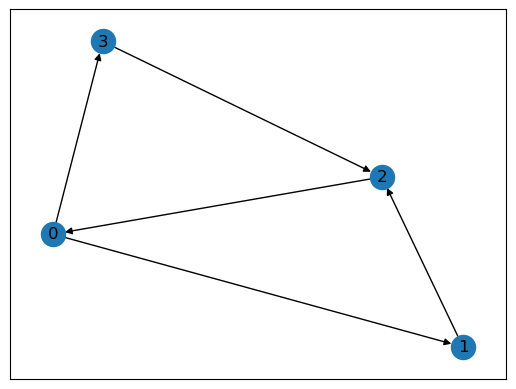

In [11]:
#see https://www.electronics-tutorials.ws/dccircuits/dcp_6.html
W=nx.DiGraph()
W.add_edges_from([(0,1),(0,3),(2,0),(1,2),(3,2)])

nx.draw_networkx(W)

W.add_nodes_from(range(4))
W.nodes[0]['potential'] = 0
W.nodes[1]['potential'] = 10
W.nodes[2]['potential'] = 11.44
W.nodes[3]['potential'] = 20

for (u, v) in W.edges():
    W.edges[u,v]['weight'] = 10000
W.edges[1,2]['weight'] = 10
W.edges[3,2]['weight'] = 20
W.edges[2,0]['weight'] = 40


In [12]:
Tut=Rommes(W)
np.abs(Tut.currents()[4]) == 0.286 #Vergleich mit "Musterlösung"

/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


True

Der Wert aus er Musterlösung wird reproduziert (das Vorzeichen stimmt bei der ersten Implementierung aber noch nicht - dazu später mehr). Ich wollte nur um ein Gefühl zu bekommen auch die anderen Größen ausgeben lassen:

In [13]:
Tut.voltages()

array([ 0.  , 10.  , 20.  , 11.44])

In [14]:
Tut.resistor()

array([[10000.,     0.,     0.,     0.,     0.],
       [    0., 10000.,     0.,     0.,     0.],
       [    0.,     0.,    10.,     0.,     0.],
       [    0.,     0.,     0.,    20.,     0.],
       [    0.,     0.,     0.,     0.,    40.]])

In [15]:
Tut.incidence()

/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


array([[-1.,  1.,  0.,  0.],
       [-1.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  1.],
       [ 0.,  0., -1.,  1.],
       [ 1.,  0.,  0., -1.]])

Ich habe mich gefragt, wie die Matrix zu verstehen ist. Nach ein bisschen nachdenken ergibt sich   
**Struktur der Inzidenzmatrix:**   
[Widerstand 1]   
[Widerstand 2]   
[Widerstand 3]     
bzw.   
[N N N N]   
[O O O O]   
[D D D D]   
[E E E E]   
[1 2 3 4]   

In [16]:
#Alle Ströme
Tut.currents()

/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


array([-0.001, -0.002, -0.144,  0.428,  0.286])

Im Beispiel wird der richtige Zahlenwert für die gesuchte Größe produziert, das Vorzeichen stimmt aber (in der ersten Implementierung) nicht, da die Inzidenzmatrix keine VZ vergibt und es musste ein sehr hoher (aber endlicher) Widerstand über die Spannungsquellen angenommen werden, weil das System diese Bauelement nicht kennt. Auch stimmen die anderen Ströme nicht mit den Werten aus anderen Rechnungen überein.

**Idee** *Vielleicht kann der Fehler in der Inzidenzmatrix behoben werden, wenn die VZ aus Potentialdifferenzen abgeschätzt wird.*

Habe das "Problem" behoben, indem ich den Graph orientiert habe und dabei die Orientierungen aus der Skizze übernommen habe. Die Lösung ist nun identisch zur Musterlösung (inkl. VZ).

**Note**  
Wahrscheinlich kann auch das "Problem" mit den künstlichen Widerständen umgangen werden, wenn man einfach keine Edge zuweißt und nur die Potentialdifferenz über die Nodes berücksichtigt.

**Orientierung**
Die Sache mit den VZ ist super, wenn man eine Skizze hat aus der man dann beim Initialisieren die Richtung entnehmen kann, aber für unsere finale Version wird das wahrscheinlich nicht praktikabel sein. Es folgt ein Ansatz um die Orientierung auf jedem Widerstand nach dem Potential auszurichten.

In [17]:
#Ansatz falls die Orientierung ungünstig ist
Mat=Tut.incidence()
V=Tut.voltages()
for x in range(np.shape(Mat)[0]):
    Y=[]
    for y in range(np.shape(Mat)[1]):
        if Mat[x,y] !=0:
            Y.append(y)
    Mat[x,Y[0]]=-np.sign(V[Y[0]]-V[Y[1]])
    Mat[x,Y[1]]=-Mat[x,Y[0]]
Mat

/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


array([[ 1., -1.,  0.,  0.],
       [ 1.,  0., -1.,  0.],
       [ 0.,  1.,  0., -1.],
       [ 0.,  0., -1.,  1.],
       [ 1.,  0.,  0., -1.]])

In [18]:
- np.matmul(np.matmul(np.linalg.inv(Tut.resistor()) , Mat) , Tut.voltages())

array([0.001, 0.002, 0.144, 0.428, 0.286])

*Die Werte sind nun alle positiv - alle Ströme sind so orientiert, dass der Strom von hohem zu niedrigen Potential fließt*

#### Wheatstone Brücke
Als zweites Beispiel eine Wheatstone-Brückenschaltung

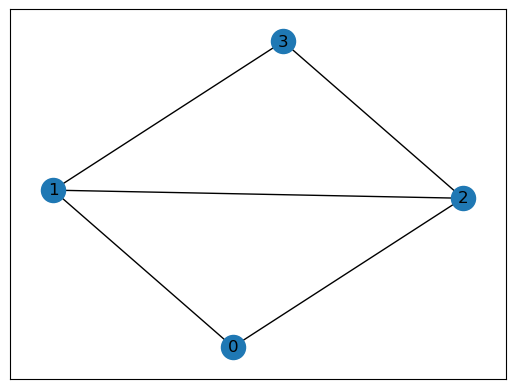

In [19]:
#see https://www.youtube.com/watch?v=04E7zPdOEh8
B=nx.Graph()
B.add_nodes_from(range(4))
B.add_edges_from([(0,1),(0,2),(1,3),(1,2),(3,2)])

nx.draw_networkx(B)


B.nodes[0]['potential'] = 0
B.nodes[1]['potential'] = 7.86
B.nodes[2]['potential'] = 7.38
B.nodes[3]['potential'] = 10

B.edges[0,1]['weight'] = 4
B.edges[1,2]['weight'] = 3
B.edges[3,2]['weight'] = 2
B.edges[2,0]['weight'] = 5
B.edges[1,3]['weight'] = 1


In [20]:
Wheat=Rommes(B)
Wheat.currents()

/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


array([-1.965, -1.476, -2.14 ,  0.16 , -1.31 ])

Die Zahlen Werte werden bis auf wenige Prozent Abweichung erreicht (würde ich auf die Rundung in der Ressource schieben). Die Stromvorzeichen sind allerdings zufällig.

#### 3D Kubus
Um die Veralgemeinerung des Systems auch in 3D zu testen wurde ein simpler 2x2x2 Würfel getestet. Hier gab es keine Musterlösung, deshalb werden die einzelnen Ströme auch Punktweise berechnet und verglichen.

/tmp/ipykernel_12636/29982126.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A3=nx.adjacency_matrix(K, dtype = "float32")


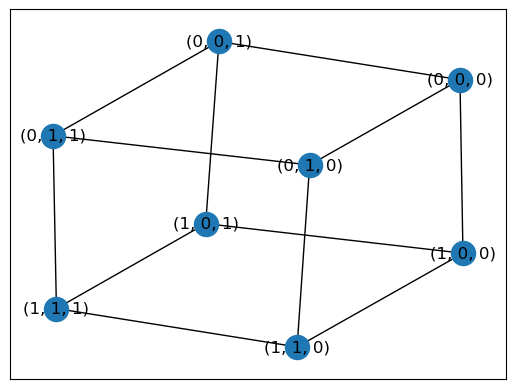

In [21]:
#Initialize Lattice
x1=2
x2=2
x3=2
K = nx.grid_graph(dim=(x1,x2,x3)) #3D Grid
#Adjacency Matrix
A3=nx.adjacency_matrix(K, dtype = "float32")

# 3D Resistances

for (u, v) in K.edges():
    K.edges[u,v]['weight'] = 1


#Randomize 3D Potentials
P_0=0
sigmaP=0.5

for (i,j,k) in G3.nodes:
    K.nodes[i,j,k]['potential'] = random.normalvariate(P_0, sigmaP)
labelsK = nx.get_node_attributes(K, 'potential') 

#Draw
nx.draw_networkx(K)

In [22]:
Kub=Rommes(K)
Kub.currents()

/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


array([-0.36003214, -0.19419911,  0.00284545,  0.12115078,  0.25405622,
       -0.07662268,  0.45110078, -0.02957312,  0.08921036,  0.48402837,
        0.10333231,  0.49815033])

In [23]:
x=[]
for (i,j) in K.edges():
    x.append(K.nodes[i]["potential"]-K.nodes[j]["potential"]) #Verwende dass R=1
np.array_equal(x,Kub.currents())

/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


True

Auch in 3D funktioniert der Algorithmus. Allerdings bin ich über die Frage gestolpert, ob unser Problem nicht auch durch die hier verwendetete Formel zur Berechnung des Stromes über die Differenz der Potentiale (geteilt durch den Widerstand) effizienter gelöst werden könnte. Das wird wohl davon abhängen, wie oft man das ganze System gelöst braucht und wie oft man immer nur einzelne Knoten betratet und wissen will wohin ein Teilchen weiterwandert.

### Following the Paper: Green's Function for Random Resistor Networks - Bhattacharjee und Ramola 2023

*Das Vorgehen ist eine Fortsetzung des Papers: Application of the lattice Greens function for calculating the resistance of an infinite network of resistors - Cserti 2000*

Zu lösen ist im Paper die Gleichung
$$
L \mid V \rangle + \mid I\rangle =0
$$
 mit der Leitfäghigkeitsmatrix (oder Gitterlaplacian)
 $$
[\mathbf{L}]_{i j}:= \begin{cases}-\sum_{j \text { with }\langle i j\rangle}\left(R_{i j}\right)^{-1} & \text { if } i=j \\ \left(R_{i j}\right)^{-1} & \text { if }\langle i j\rangle \\ 0 & \text { otherwise. }\end{cases}
$$
Es ist zu beachten, dass die  $\mid I \rangle$ die Ströme an den Knotenpunkten sind. Die Ströme über die Widerstände sind
$$
\mid J_{\hat{e}}\rangle_{i} = \frac{\mid V \rangle _{i} - \mid V \rangle _{j}}{R_{ij}}  \text{   mit } \langle ij \rangle _{\hat{e}}
$$

Es wird dann die Greensfuntkion
$$
G=L^{-1}
$$
definiert und gesucht. Durch die Summenregel in Kichhoffsgesetz ist $L$ nicht invertierbar und wir deshalb aus der Nullmode $\mid 0 \rangle = (1 1 1 1 )^T$ herausprojeziert (???). Damit ist dann
$$
LG=GL=-(\mathbb{1} - \mid 0 \rangle \langle 0  \mid)
$$
Die Inverse $G$ kann entweder nummerisch, oder mit dem im Paper vorgeschlagenen Ansatz als Greensfunktion des perfekten Gitters und Korrekturen berechnet werden.   
Die Ströme über die Widerstände können aus
aus
$$
D_{\hat{e}}\left|V\right\rangle + \left|J_{\hat{e}}\right\rangle =0
$$

als 
$$
\left|J_{\hat{e}}\right\rangle=-\mathrm{D}_{\hat{e}}|V\rangle
$$
berechnet werden, sobald die Spannungen bekannt sind. Dabei ist die Differenzmatrix $D_{\hat{e}}$ definiert als
$$
\left[\mathrm{D}_{\hat{e}}\right]_{i j}:=\left(R_{\langle i j\rangle_{\hat{e}}}\right)^{-1} \begin{cases}-1 & \text { if } i=j \\ 1 & \text { if }\langle i j\rangle_{\hat{e}} \\ 0 & \text { otherwise }\end{cases}
$$


Es bleibt unklar wie die Widerstände der Diagonalelemente zu verstehen sind.

In [24]:
class Ramola:
    def __init__(self, G):
        self.G=G
        self.N=self.G.order()
        self.nR=self.G.number_of_edges()
        
        
    def Diff(self):
        adj=nx.adjacency_matrix(self.G, weight=None) #Finde Verbindungen
        Diff=np.zeros(adj.shape)
        for (u, v) in self.G.edges():
            Diff[u,v]=1/self.G.edges[u,v]['weight']
            Diff[v,u]=-1/self.G.edges[u,v]['weight'] #neg. VZ für Orientierung der Ströme 
        
        #Hier müsste noch ein Teil für die Diagonalelemente sein - aber was sollen die Widerstandswerte bedeuten?
        
        return Diff
    
    def voltages(self):
        #Get the potential values from the nodes and build a vector
        vec=np.zeros(self.N)
        i=0
        for u in self.G.nodes:
            vec[i]=self.G.nodes[u]['potential']
            i+=1
        return vec    
    
    def currents(self):
        #Combines the other functions to get the currents trough the resistors
        return - np.matmul(np.linalg.inv(self.Diff()) , self.voltages())

**Baustelle**
Die folgenden Zellen sind Schnipsel die ich zum Zusammenbasteln verwendet habe

In [25]:
adj=nx.adjacency_matrix(B, weight=None)
Diff=np.zeros(adj.shape)
for (u, v) in B.edges():
    Diff[u,v]=1/B.edges[u,v]['weight']
    Diff[v,u]=-1/B.edges[u,v]['weight'] 

/tmp/ipykernel_12636/1336809589.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj=nx.adjacency_matrix(B, weight=None)


In [26]:
Diff

array([[ 0.        ,  0.25      ,  0.2       ,  0.        ],
       [-0.25      ,  0.        ,  0.33333333,  1.        ],
       [-0.2       , -0.33333333,  0.        ,  0.5       ],
       [ 0.        , -1.        , -0.5       ,  0.        ]])

In [27]:
Ram=Ramola(W)
print(Ram.currents())
#Zum Vergleich
print(Tut.currents())

[ 1.288e+05  5.760e+04  2.880e+01 -5.040e+04]
[-0.001 -0.002 -0.144  0.428  0.286]


/tmp/ipykernel_12636/2507483383.py:9: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj=nx.adjacency_matrix(self.G, weight=None) #Finde Verbindungen
/tmp/ipykernel_12636/2555061245.py:18: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  mat= np.transpose(nx.incidence_matrix(self.G, oriented=1).todense())


Der Output ist mit fehlenden Diagonalelementen wie zu erwarten Müll.

### Following Paper: Theory of resistor networks: the two-point resistance: Wu 2004

Zu Lösen ist 
$$
\mathbf{L} \vec{V}=\vec{I}
$$
mit den Knotenpotentialen, den **Knotenströmen** und der Leitfähigkeitsmatrix
$$
\mathbf{L}=\left(\begin{array}{cccc}
c_1 & -c_{12} & \cdots & -c_{1 \mathcal{N}} \\
-c_{21} & c_2 & \cdots & -c_{2 N} \\
\vdots & \vdots & \ddots & \vdots \\
-c_{N 1} & -c_{N 2} & \cdots & c_{\mathcal{N}}
\end{array}\right)
$$
dabei sind die Offdiagonalelemente die Reziproken der Widerstandswerte der Verbindungen und die Diagonalelemente
$$
c_i \equiv \sum_{j=1}^{\mathcal{N}} c_{i j}^{\prime}
$$
Als Randbedingungen gelten die Kirchhoff Gesetze

$$
\sum_{j=1}^{\mathcal{N}}{ }^{\prime} c_{i j}\left(V_i-V_j\right)=I_i \quad i=1,2, \ldots, \mathcal{N} \text{ ohne i=j}
$$

und

$$
\sum_{i=1}^{\mathcal{N}} I_{i} =0
$$


Null ist ein Eigenvektor von $L$, weshalb die Matrix nicht ohne Weiteres invertiert werden kann. Es wird ein kleiner Term addiert
$$
L(\epsilon) = L + \epsilon \mathbb{1}
$$
$\epsilon$ wird am Ende auf Null gesetzt.
Mit der Greensfunktion $G$ als Inverse von $L $ werden die Potentiale als $\vec{V}(\epsilon) = G(\epsilon) \vec{I}$ berechnet.  
Dafür wird nun die unitäre Matrix $U$ gesucht die $L$ diagonalisiert
$$
U^{\dagger} L(\epsilon) U = \Lambda (\epsilon)
$$
dabei hat die Matrix $\Lambda$ die Eigenwerte (bzw. ihre um $\epsilon$ verschobenen Werte) von $L$ auf der Hauptdiagonalen. Die Matrix $U$ hat die Eigenvektorelemente $U_{ij}=\Psi_{ij}$.   
Damit ist
$$
G_{\alpha \beta}(\epsilon)=\sum_{i=1}^{\mathcal{N}} U_{\alpha i}\left(\frac{1}{\lambda_i+\epsilon}\right) U_{\beta i}^*
$$
oder die (in diesem Paper gesuchenten) Widerstände
$$
R_{\alpha \beta}=\sum_{i=2}^{\mathcal{N}} \frac{1}{\lambda_i}\left|\psi_{i \alpha}-\psi_{i \beta}\right|^2
$$

Leider wird hier nicht auf die Ströme über die Widerstände eingegangen.   


Im Weiteren heißt es aber in dem Paper, dass die Widerstände auch Probabilistisch in Relation zu Übergangsraten interpretiert werden können. Zumindest diese Aussage, könnte interessant sein.